In [1]:
# KT Noted: Using CUBEMS environment
# KT Noted: ChatGPT o3-mini-high (4 Feb 2025)

In [2]:
import time
import pandas as pd
import numpy as np
from scipy import stats

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [4]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
# Set a global random seed
SEED = 42
np.random.seed(SEED)

In [6]:
# -------------------------------
# 1. Data Preparation & Splitting
# -------------------------------

In [7]:
# Load the CSV file
file_path = r"C:\Users\kornn\Dropbox\00_EnergyModel_Weather\Dataset\Training_Combinded\train_df.csv"  
train_df = pd.read_csv(file_path)
train_df.head()

,Date,Total_kWh,Hour_of_Day,Day_of_week,Holiday,Weekend,Weekday,Working_Hour,Noon,Temperature,Dew Point,Humidity,Pressure,Solar
0,2018-07-01 00:00:00,176.261667,0,6,0,1,0,0,0,25.0,24.2,95,1006.43,0
1,2018-07-01 01:00:00,177.300000,1,6,0,1,0,0,0,25.5,24.8,96,1006.43,0
2,2018-07-01 02:00:00,177.048833,2,6,0,1,0,0,0,25.8,24.9,95,1005.76,0
3,2018-07-01 03:00:00,175.129167,3,6,0,1,0,0,0,25.7,24.7,94,1005.08,0
4,2018-07-01 04:00:00,183.175000,4,6,0,1,0,0,0,26.3,24.6,90,1005.42,0


In [8]:
train_df['Date'] = pd.to_datetime(train_df['Date']) # Make Date column is in datetime format

In [9]:
# Train and Test Split 
train_set = (train_df['Date'] >= '2018-07-01 00:00:00') & (train_df['Date'] <= '2019-06-30 23:00:00')
test_set = (train_df['Date'] >= '2019-07-01 00:00:00') & (train_df['Date'] <= '2019-08-31 23:00:00')

In [10]:
# Create the training and test DataFrames
train_data = train_df.loc[train_set].copy()
test_data = train_df.loc[test_set].copy()

In [11]:
# -------------------------------
# 2. Set Features and Target
# -------------------------------

In [12]:
target_col = 'Total_kWh' # Set the target variable
feature_cols = [col for col in train_df.columns if col not in ['Date', target_col]] # Set the features

In [13]:
X_train = train_data[feature_cols]
y_train = train_data[target_col]
X_test = test_data[feature_cols]
y_test = test_data[target_col]

In [14]:
# -------------------------------
# 3. Model Training with LightGBM
# -------------------------------

In [15]:
# These are the fixed parameters that are not being tuned.
base_params = {
    'objective': 'regression',   # The loss function.
    'feature_fraction': 0.9,     # Fraction of features used per iteration.
    'bagging_fraction': 0.8,     # Fraction of training data used per iteration.
    'bagging_freq': 5,           # How often (in iterations) to perform bagging.
    'random_state': SEED,        # For reproducibility.
    'force_col_wise': True       # Ensures column-wise data storage, reducing memory overhead
}

In [16]:
# These are the core hyperparameters.
param_grid = {
    'learning_rate': [0.005, 0.01, 0.02],   # Shrinks the contribution of each tree.
    'num_leaves': [50, 70, 90],             # Maximum number of leaves per tree (controls model complexity).
    'max_depth': [10, 15, 20],              # Maximum tree depth (-1 means no limit).
    'n_estimators': [500, 1000, 2000]        # Maximum number of boosting iterations.
}

In [17]:
# select the model
model = LGBMRegressor(**base_params) # Initialize the model

In [18]:
# Set Up GridSearchCV
grid_search = GridSearchCV(
    estimator = model,          # The model (LightGBM)
    param_grid = param_grid,    # The dictionary of hyperparameters to test
    cv = 5,                     # n-fold cross-validation
    scoring ='neg_mean_squared_error',  # Using negative MSE as the scoring metric.
    verbose = 1,                        # Prints progress of the search
    n_jobs = -1                         # Use all available cores on the machine
)

In [19]:
# Start timing before training
start_time = time.time()

In [20]:
# The additional parameters (eval_set, eval_metric, callbacks) are passed to each call of model.fit()
grid_search.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(period=100)
    ]
)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


c:\Users\kornn\anaconda3\envs\CUBEMS\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\kornn\anaconda3\envs\CUBEMS\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\kornn\anaconda3\envs\CUBEMS\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\kornn\anaconda3\envs\CUBEMS\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\kornn\anaconda3\envs\CUBEMS\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(exec

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 8760, number of used features: 12
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current v

GridSearchCV(cv=5,
             estimator=LGBMRegressor(bagging_fraction=0.8, bagging_freq=5,
                                     feature_fraction=0.9, force_col_wise=True,
                                     objective='regression', random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.005, 0.01, 0.02],
                         'max_depth': [10, 15, 20],
                         'n_estimators': [500, 1000, 2000],
                         'num_leaves': [50, 70, 90]},
             scoring='neg_mean_squared_error', verbose=1)

In [21]:
# End timing after training
end_time = time.time()
training_time = end_time - start_time # Calculate training duration
print(f"Model training time: {training_time/60:.2f} minutes") 

Model training time: 14.69 minutes


In [22]:
# Retrieve the best model:
best_model = grid_search.best_estimator_
best_model

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.9,
              force_col_wise=True, learning_rate=0.005, max_depth=15,
              n_estimators=2000, num_leaves=70, objective='regression',
              random_state=42)

In [23]:
# ---------------------------------------------
#  Retrain the best model using full train set 
# ---------------------------------------------

In [24]:
best_model.fit(X_train, y_train) # Retrain the best model using the full train set

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 8760, number of used features: 12
[LightGBM] [Info] Start training from score 259.028486
[LightGBM] [Warning] No further splits wit

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.9,
              force_col_wise=True, learning_rate=0.005, max_depth=15,
              n_estimators=2000, num_leaves=70, objective='regression',
              random_state=42)

In [25]:
# -------------------------------
#  Result on Train set 
# -------------------------------

In [26]:
# Calculate evaluation metrics: RMSE, CV(RMSE), NMBE, and R2
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))    # using sklearn's mean_squared_error function
    cv_rmse = (rmse / np.mean(y_true)) * 100
    nmbe = (np.mean(y_pred - y_true) / np.mean(y_true)) * 100
    r2 = r2_score(y_true, y_pred)                         # using sklearn's r2_score function
    return {'rmse': rmse, 'cv_rmse': cv_rmse, 'nmbe': nmbe, 'r2': r2}

In [27]:
# Predict on the training set using the best_model 
y_train_pred = best_model.predict(X_train) 
train_metrics = evaluate_model(y_train, y_train_pred)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [28]:
print("Evaluation Metrics on Train Set (GridSearch CoreParams):")
print("RMSE: {:.3f}".format(train_metrics['rmse']))
print("CV(RMSE): {:.2f}%".format(train_metrics['cv_rmse']), "| IPMVP < 20% | ASHRAE & FEMP < 30%")
print("NMBE: {:.2f}%".format(train_metrics['nmbe']), "| IPMVP < 5% | ASHRAE & FEMP < 10%")
print("R2 Score: {:.3f}".format(train_metrics['r2']), "| IPMVP & ASHRAE > 0.75 | FEMP = NA")

Evaluation Metrics on Train Set (GridSearch CoreParams):
RMSE: 36.101
CV(RMSE): 13.94% | IPMVP < 20% | ASHRAE & FEMP < 30%
NMBE: 0.00% | IPMVP < 5% | ASHRAE & FEMP < 10%
R2 Score: 0.967 | IPMVP & ASHRAE > 0.75 | FEMP = NA


In [29]:
# -------------------------------
# 5. Model Evaluation on Test set
# -------------------------------

In [30]:
# Predict on the test set using the best_model 
y_pred = best_model.predict(X_test)  
test_metrics = evaluate_model(y_test, y_pred)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [31]:
print("Evaluation Metrics on Test Set (GridSearch CoreParams):")
print("RMSE: {:.3f}".format(test_metrics['rmse']))
print("CV(RMSE): {:.2f}%".format(test_metrics['cv_rmse']), "| IPMVP < 20% | ASHRAE & FEMP < 30%")
print("NMBE: {:.2f}%".format(test_metrics['nmbe']), "| IPMVP < 5% | ASHRAE & FEMP < 10%")
print("R2 Score: {:.3f}".format(test_metrics['r2']), "| IPMVP & ASHRAE > 0.75 | FEMP = NA")

Evaluation Metrics on Test Set (GridSearch CoreParams):
RMSE: 61.502
CV(RMSE): 21.47% | IPMVP < 20% | ASHRAE & FEMP < 30%
NMBE: -0.89% | IPMVP < 5% | ASHRAE & FEMP < 10%
R2 Score: 0.932 | IPMVP & ASHRAE > 0.75 | FEMP = NA


In [32]:
# -------------------------------
# 5. Plots
# -------------------------------

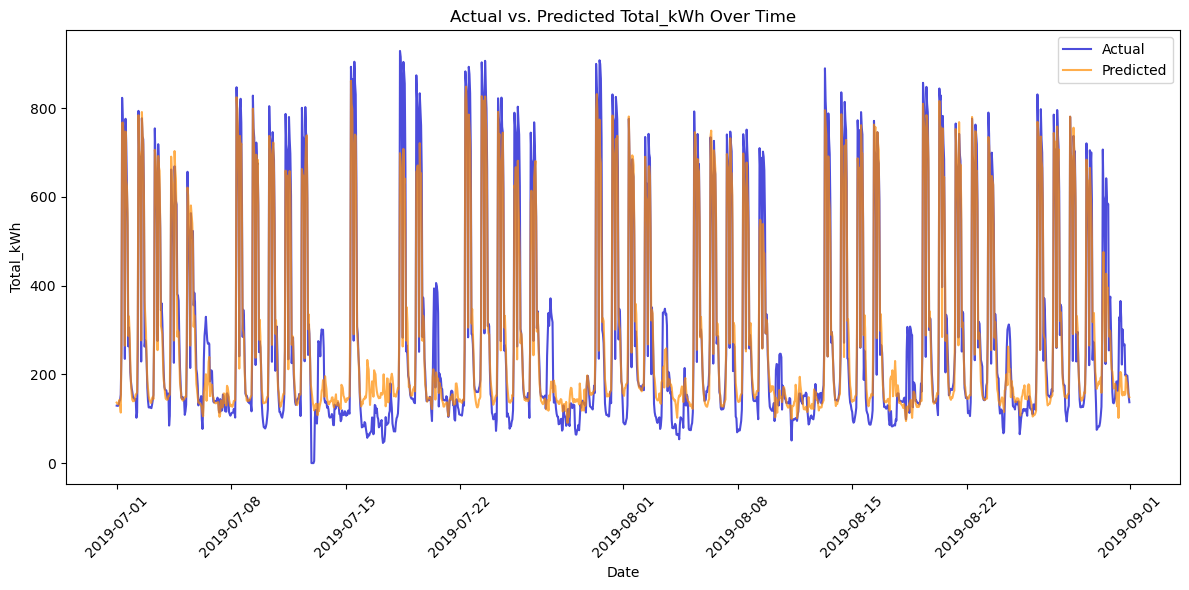

In [33]:
# (a) Actual vs. Predicted over time
plt.figure(figsize=(12,6))
plt.plot(test_data['Date'], y_test, label='Actual', linestyle='-', alpha=0.7,color='mediumblue')
plt.plot(test_data['Date'], y_pred, label='Predicted', linestyle='-', alpha=0.7, color='darkorange')
plt.xlabel('Date')
plt.ylabel('Total_kWh')
plt.title('Actual vs. Predicted Total_kWh Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\kornn\AppData\Local\Temp\ipykernel_28284\297648835.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='black')  # 45-degree line


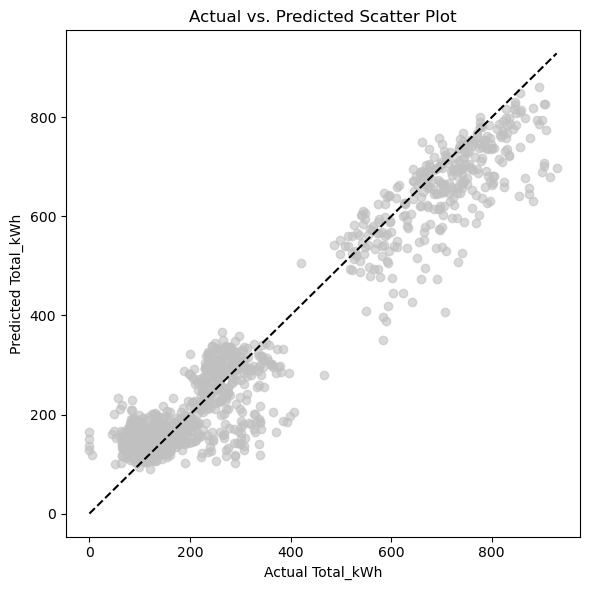

In [34]:
# (b) Scatter plot of Actual vs. Predicted values
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='silver')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='black')  # 45-degree line
plt.xlabel('Actual Total_kWh')
plt.ylabel('Predicted Total_kWh')
plt.title('Actual vs. Predicted Scatter Plot')
plt.tight_layout()
plt.show()

C:\Users\kornn\AppData\Local\Temp\ipykernel_28284\2116981897.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_importance, palette="viridis")


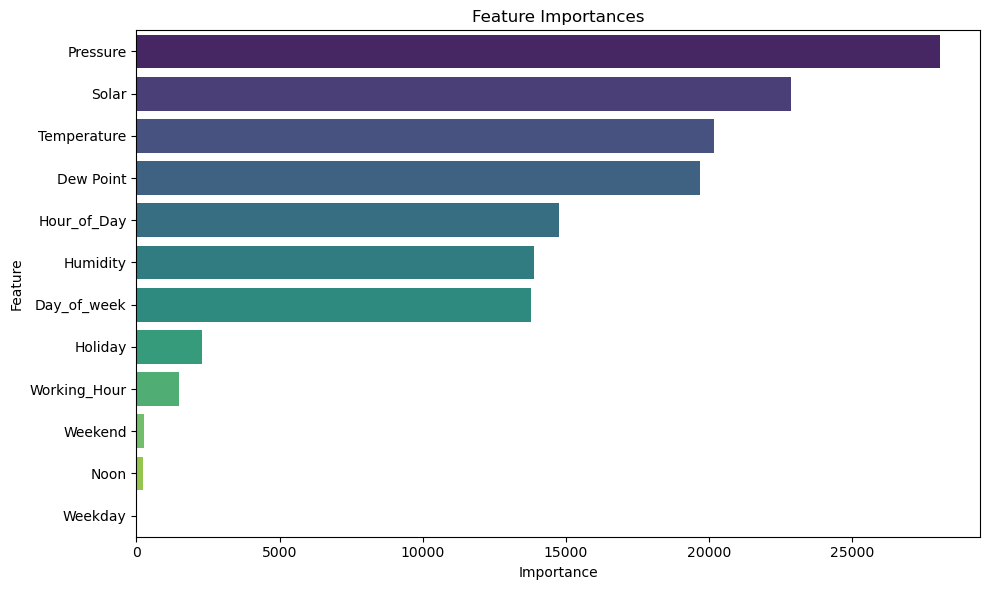

In [35]:
# (c) Feature Importance
importance = best_model.feature_importances_
feat_importance = pd.DataFrame({'feature': feature_cols, 'importance': importance})
feat_importance = feat_importance.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_importance, palette="viridis")
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [36]:
# -------------------------------
# 6. Residual Plots
# -------------------------------

In [37]:
# Calculate residuals
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_pred

# Determine Min-Max for common y-axis limits
residual_min = min(residuals_train.min(), residuals_test.min())
residual_max = max(residuals_train.max(), residuals_test.max())

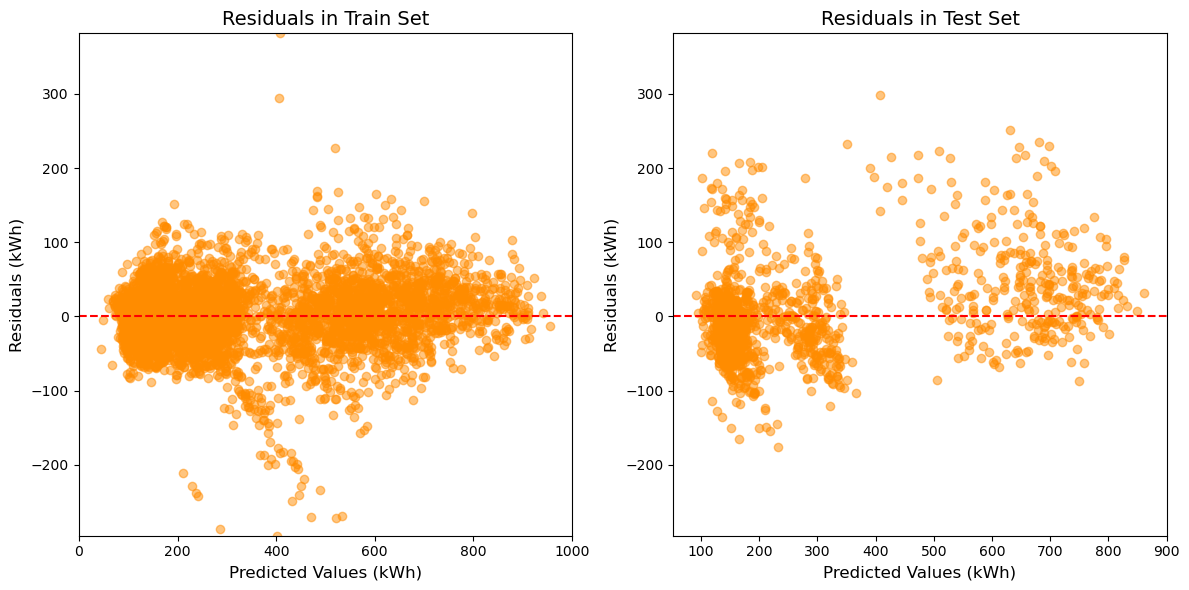

In [38]:
# Plot residuals
plt.figure(figsize=(12, 6))

# Train residuals
plt.subplot(1, 2, 1)
plt.scatter(y_train_pred, residuals_train, color='darkorange', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.ylim(residual_min, residual_max)
plt.title('Residuals in Train Set', fontsize=14)
plt.xlabel('Predicted Values (kWh)', fontsize=12)
plt.ylabel('Residuals (kWh)', fontsize=12)

# Test residuals
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals_test, color='darkorange', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.ylim(residual_min, residual_max)
plt.title('Residuals in Test Set', fontsize=14)
plt.xlabel('Predicted Values (kWh)', fontsize=12)
plt.ylabel('Residuals (kWh)', fontsize=12)

plt.tight_layout()
plt.show()

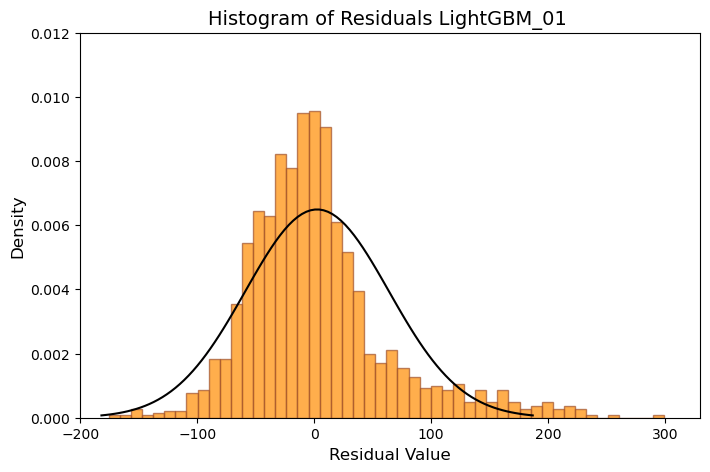

In [42]:
# Histogram of Residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals_test, bins=50, density=True, alpha=0.7, color="darkorange", edgecolor="sienna")

# Calculate mean and standard deviation
mu, sigma = np.mean(residuals_test), np.std(residuals_test)

# Plot normal distribution curve
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color="black", linewidth=1.5)

# Add labels and title
plt.xlabel("Residual Value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Histogram of Residuals LightGBM_01 ", fontsize=14)

plt.xlim(-200, 330)  # Set x-axis limit
plt.ylim(0, 0.012) # Set y-axis limit

# Display plot
plt.show()

In [40]:
# Residual statistics
residual_stats = {
    "Mean": np.mean(residuals_test),
    "Variance": np.var(residuals_test),
    "Skewness": stats.skew(residuals_test),     # skewness / asymmetry of the distribution
    "Kurtosis": stats.kurtosis(residuals_test)  # tailedness of the distribution
}
# Display residual statistics in a DataFrame
residual_df_summary = pd.DataFrame(residual_stats, index=["Residuals"])
print(residual_df_summary.round(3))

            Mean  Variance  Skewness  Kurtosis
Residuals  2.551  3776.012      1.16     2.245


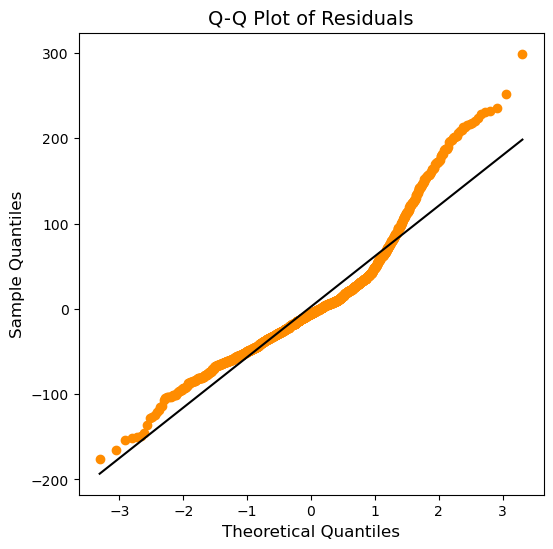

In [41]:
# Q-Q Plot for Normality Check
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)  # Add subplot to get axis object

# Generate Q-Q plot
stats.probplot(residuals_test, dist="norm", plot=ax)

# Customize colors
ax.get_lines()[0].set_color('darkorange')  # Data points
ax.get_lines()[1].set_color('black')       # 45-degree line

# Add titles and labels
ax.set_title("Q-Q Plot of Residuals", fontsize=14)
ax.set_xlabel("Theoretical Quantiles", fontsize=12)
ax.set_ylabel("Sample Quantiles", fontsize=12)

# Display plot
plt.show()

In [ ]:
############## The End ##############